# NURBS Meta-Atoms Simulation Test

This notebook tests the `nurbs_atoms_data.py` simulation and generates training data.

**Note**: Make sure to activate the parallel Meep Python environment before running this notebook.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys

# Add current directory to path
sys.path.insert(0, os.getcwd())

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Test Meep import
try:
    import meep as mp
    print(f"Meep version: {mp.__version__}")
    print("Meep imported successfully!")
except ImportError as e:
    print(f"Error importing Meep: {e}")
    print("Please make sure to activate the parallel Meep environment.")

Using MPI version 4.1, 1 processes
Meep version: 1.31.0
Meep imported successfully!


In [3]:
# Import the Simulation class from nurbs_atoms_data
from nurbs_atoms_data import Simulation, sort_points_ccw

print("Simulation class imported successfully!")

Simulation class imported successfully!


## 1. Test Single Simulation

In [4]:
# Define default control points
default_control_points = np.array([
    (0.18, 0), (0.16, 0.16), (0, 0.18), (-0.16, 0.16),
    (-0.18, 0), (-0.16, -0.16), (0, -0.16), (0.16, -0.16)
])

print("Control points:")
print(default_control_points)

Control points:
[[ 0.18  0.  ]
 [ 0.16  0.16]
 [ 0.    0.18]
 [-0.16  0.16]
 [-0.18  0.  ]
 [-0.16 -0.16]
 [ 0.   -0.16]
 [ 0.16 -0.16]]


In [5]:
# Create Simulation object
print("Creating Simulation object...")
sim = Simulation(control_points=default_control_points)
print("Simulation object created successfully!")

Creating Simulation object...
Simulation object created successfully!


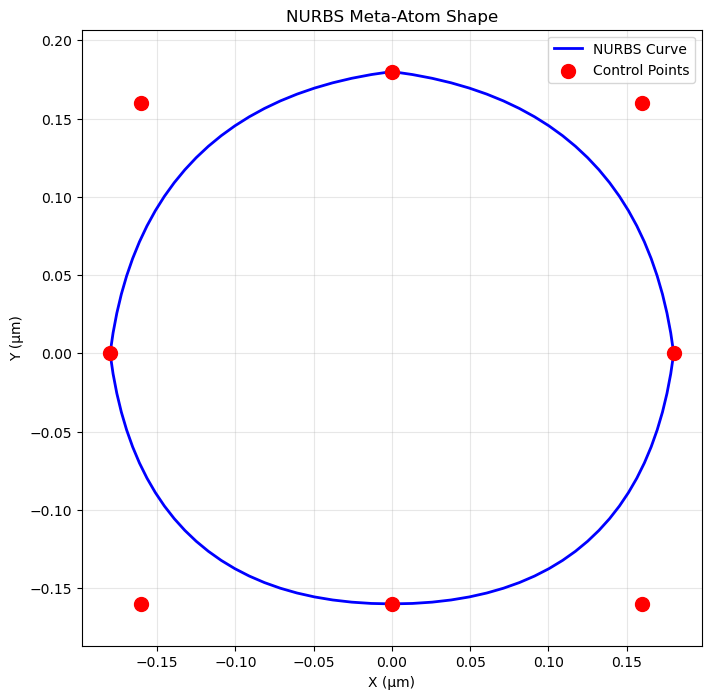

In [6]:
# Visualize the NURBS curve
nurbs_points = sim.generate_complete_nurbs_curve(default_control_points)

# Extract x and y coordinates
x_coords = [p[0] for p in nurbs_points]
y_coords = [p[1] for p in nurbs_points]

# Close the curve
x_coords.append(x_coords[0])
y_coords.append(y_coords[0])

plt.figure(figsize=(8, 8))
plt.plot(x_coords, y_coords, 'b-', linewidth=2, label='NURBS Curve')
plt.scatter(default_control_points[:, 0], default_control_points[:, 1], 
            c='red', s=100, zorder=5, label='Control Points')
plt.axis('equal')
plt.title('NURBS Meta-Atom Shape')
plt.xlabel('X (μm)')
plt.ylabel('Y (μm)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [7]:
# Run a single simulation
print("Running forward simulation...")
print("This may take a few minutes...")

wavelength = 550e-9  # 550 nm
transmittance, phase = sim.run_forward(wavelength_start=wavelength, wavelength_stop=wavelength)

print(f"\nSimulation Results:")
print(f"  Transmittance: {transmittance:.6f}")
print(f"  Phase: {phase:.6f} radians ({np.degrees(phase):.2f} degrees)")

Running forward simulation...
This may take a few minutes...
-----------
Initializing structure...
time for choose_chunkdivision = 1.42e-05 s
Working in 3D dimensions.
Computational cell is 0 x 0 x 0 with resolution 50
     block, center = (0,0,-5e-06)
          size (1e+20,1e+20,1e-05)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     prism, center = (0,0,3e-07)
          height 6e-07, axis (0,0,1), sidewall angle: 0 radians, 96 vertices:
          (-1.8e-07,-3.33623e-09,0)
          (-1.7809e-07,-1.63918e-08,0)
          (-1.75694e-07,-2.88918e-08,0)
          (-1.72813e-07,-4.08362e-08,0)
          (-1.69444e-07,-5.22251e-08,0)
          (-1.6559e-07,-6.30584e-08,0)
          (-1.6125e-07,-7.33362e-08,0)
          (-1.56424e-07,-8.30584e-08,0)
          (-1.51111e-07,-9.22251e-08,0)
          (-1.45313e-07,-1.00836e-07,0)
          (-1.39028e-07,-1.08892e-07,0)
          (-1.32257e-07,-1.16392e-07,0)
          (-1.25e-07,

## 2. Generate Training Data

In [8]:
def generate_training_data(n_samples=10, wavelength=550e-9, perturbation_range=0.03):
    """
    Generate training data by running simulations with perturbed control points.
    
    Args:
        n_samples: Number of samples to generate
        wavelength: Wavelength for simulation (in meters)
        perturbation_range: Range of random perturbation for control points
    
    Returns:
        control_points_list: List of control point arrays
        results_list: List of (transmittance, phase) tuples
    """
    base_control_points = np.array([
        (0.18, 0), (0.16, 0.16), (0, 0.18), (-0.16, 0.16),
        (-0.18, 0), (-0.16, -0.16), (0, -0.16), (0.16, -0.16)
    ])
    
    control_points_list = []
    results_list = []
    
    for i in tqdm(range(n_samples), desc="Generating samples"):
        # Add random perturbation
        perturbation = np.random.uniform(-perturbation_range, perturbation_range, (8, 2))
        current_control_points = base_control_points + perturbation
        current_control_points = np.clip(current_control_points, -0.22, 0.22)
        
        try:
            # Create simulation and run
            sim = Simulation(control_points=current_control_points)
            transmittance, phase = sim.run_forward(
                wavelength_start=wavelength, 
                wavelength_stop=wavelength
            )
            
            control_points_list.append(current_control_points)
            results_list.append((transmittance, phase))
            
            print(f"Sample {i+1}: Trans={transmittance:.4f}, Phase={phase:.4f}")
            
        except Exception as e:
            print(f"Sample {i+1} failed: {e}")
    
    return control_points_list, results_list

In [9]:
# Generate a small batch of training data
# Adjust n_samples as needed (more samples = longer time)
n_samples = 5  # Start with a small number to test

print(f"Generating {n_samples} training samples...")
print("This will take some time as each simulation runs...\n")

control_points_data, results_data = generate_training_data(n_samples=n_samples)

Generating 5 training samples...
This will take some time as each simulation runs...



Generating samples:   0%|          | 0/5 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


-----------
Initializing structure...
time for choose_chunkdivision = 6.9e-06 s
Working in 3D dimensions.
Computational cell is 0 x 0 x 0 with resolution 50
     block, center = (0,0,-5e-06)
          size (1e+20,1e+20,1e-05)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     prism, center = (0,0,3e-07)
          height 6e-07, axis (0,0,1), sidewall angle: 0 radians, 96 vertices:
          (-1.86136e-07,-6.37544e-09,0)
          (-1.81825e-07,-1.93844e-08,0)
          (-1.77233e-07,-3.17448e-08,0)
          (-1.7236e-07,-4.34564e-08,0)
          (-1.67206e-07,-5.45194e-08,0)
          (-1.61771e-07,-6.49338e-08,0)
          (-1.56054e-07,-7.46995e-08,0)
          (-1.50057e-07,-8.38165e-08,0)
          (-1.43778e-07,-9.22849e-08,0)
          (-1.37219e-07,-1.00105e-07,0)
          (-1.30378e-07,-1.07276e-07,0)
          (-1.23256e-07,-1.13798e-07,0)
          (-1.15853e-07,-1.19672e-07,0)
          (-1.08169e-07,-1.24897e-07,

Generating samples:  20%|██        | 1/5 [00:00<00:01,  2.08it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


run 0 finished at t = 400.0 (40000 timesteps)
Sample 1: Trans=0.0000, Phase=0.0000
-----------
Initializing structure...
time for choose_chunkdivision = 6e-06 s
Working in 3D dimensions.
Computational cell is 0 x 0 x 0 with resolution 50
     block, center = (0,0,-5e-06)
          size (1e+20,1e+20,1e-05)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     prism, center = (0,0,3e-07)
          height 6e-07, axis (0,0,1), sidewall angle: 0 radians, 96 vertices:
          (-1.66923e-07,-3.584e-09,0)
          (-1.68227e-07,-1.68211e-08,0)
          (-1.67202e-07,-2.96464e-08,0)
          (-1.65591e-07,-4.17494e-08,0)
          (-1.63396e-07,-5.313e-08,0)
          (-1.60617e-07,-6.37882e-08,0)
          (-1.57253e-07,-7.37241e-08,0)
          (-1.53304e-07,-8.29376e-08,0)
          (-1.48771e-07,-9.14286e-08,0)
          (-1.43653e-07,-9.91973e-08,0)
          (-1.37951e-07,-1.06244e-07,0)
          (-1.31664e-07,-1.12568e-07,0)

Generating samples:  40%|████      | 2/5 [00:00<00:01,  2.13it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


run 0 finished at t = 400.0 (40000 timesteps)
Sample 2: Trans=0.0000, Phase=0.0000
-----------
Initializing structure...
time for choose_chunkdivision = 5.3e-06 s
Working in 3D dimensions.
Computational cell is 0 x 0 x 0 with resolution 50
     block, center = (0,0,-5e-06)
          size (1e+20,1e+20,1e-05)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     prism, center = (0,0,3e-07)
          height 6e-07, axis (0,0,1), sidewall angle: 0 radians, 96 vertices:
          (-1.83422e-07,-7.74105e-09,0)
          (-1.86024e-07,-2.40723e-08,0)
          (-1.83606e-07,-3.64237e-08,0)
          (-1.80679e-07,-4.81228e-08,0)
          (-1.77244e-07,-5.91697e-08,0)
          (-1.733e-07,-6.95643e-08,0)
          (-1.68847e-07,-7.93066e-08,0)
          (-1.63886e-07,-8.83966e-08,0)
          (-1.58417e-07,-9.68343e-08,0)
          (-1.52439e-07,-1.0462e-07,0)
          (-1.45952e-07,-1.11753e-07,0)
          (-1.38957e-07,-1.18234e-07

Generating samples:  60%|██████    | 3/5 [00:01<00:00,  2.10it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


run 0 finished at t = 400.0 (40000 timesteps)
Sample 3: Trans=0.0000, Phase=0.0000
-----------
Initializing structure...
time for choose_chunkdivision = 6.3e-06 s
Working in 3D dimensions.
Computational cell is 0 x 0 x 0 with resolution 50
     block, center = (0,0,-5e-06)
          size (1e+20,1e+20,1e-05)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     prism, center = (0,0,3e-07)
          height 6e-07, axis (0,0,1), sidewall angle: 0 radians, 96 vertices:
          (-1.81567e-07,-1.08527e-08,0)
          (-1.78959e-07,-2.613e-08,0)
          (-1.75873e-07,-4.06362e-08,0)
          (-1.72309e-07,-5.43715e-08,0)
          (-1.68266e-07,-6.73359e-08,0)
          (-1.63745e-07,-7.95292e-08,0)
          (-1.58746e-07,-9.09516e-08,0)
          (-1.53268e-07,-1.01603e-07,0)
          (-1.47312e-07,-1.11483e-07,0)
          (-1.40878e-07,-1.20593e-07,0)
          (-1.33965e-07,-1.28931e-07,0)
          (-1.26574e-07,-1.36499e-0

Generating samples:  80%|████████  | 4/5 [00:01<00:00,  2.11it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


run 0 finished at t = 400.0 (40000 timesteps)
Sample 4: Trans=0.0000, Phase=0.0000
-----------
Initializing structure...
time for choose_chunkdivision = 1.46e-05 s
Working in 3D dimensions.
Computational cell is 0 x 0 x 0 with resolution 50
     block, center = (0,0,-5e-06)
          size (1e+20,1e+20,1e-05)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     prism, center = (0,0,3e-07)
          height 6e-07, axis (0,0,1), sidewall angle: 0 radians, 96 vertices:
          (-1.92138e-07,-4.13382e-09,0)
          (-1.95725e-07,-2.13391e-08,0)
          (-1.92427e-07,-3.16984e-08,0)
          (-1.88666e-07,-4.15784e-08,0)
          (-1.84442e-07,-5.09791e-08,0)
          (-1.79753e-07,-5.99005e-08,0)
          (-1.746e-07,-6.83426e-08,0)
          (-1.68984e-07,-7.63055e-08,0)
          (-1.62904e-07,-8.3789e-08,0)
          (-1.5636e-07,-9.07933e-08,0)
          (-1.49352e-07,-9.73183e-08,0)
          (-1.4188e-07,-1.03364e-07,

Generating samples: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

run 0 finished at t = 400.0 (40000 timesteps)
Sample 5: Trans=0.0000, Phase=0.0000


In [10]:
# Display results summary
if results_data:
    transmittances = [r[0] for r in results_data]
    phases = [r[1] for r in results_data]
    
    print(f"\n=== Data Generation Summary ===")
    print(f"Total samples generated: {len(results_data)}")
    print(f"\nTransmittance statistics:")
    print(f"  Mean: {np.mean(transmittances):.4f}")
    print(f"  Std:  {np.std(transmittances):.4f}")
    print(f"  Min:  {np.min(transmittances):.4f}")
    print(f"  Max:  {np.max(transmittances):.4f}")
    print(f"\nPhase statistics:")
    print(f"  Mean: {np.mean(phases):.4f} rad ({np.degrees(np.mean(phases)):.2f} deg)")
    print(f"  Std:  {np.std(phases):.4f} rad")
    print(f"  Min:  {np.min(phases):.4f} rad")
    print(f"  Max:  {np.max(phases):.4f} rad")
else:
    print("No data was generated successfully.")


=== Data Generation Summary ===
Total samples generated: 5

Transmittance statistics:
  Mean: 0.0000
  Std:  0.0000
  Min:  0.0000
  Max:  0.0000

Phase statistics:
  Mean: 0.0000 rad (0.00 deg)
  Std:  0.0000 rad
  Min:  0.0000 rad
  Max:  0.0000 rad


In [11]:
# Save the generated data
if control_points_data and results_data:
    # Convert to numpy arrays
    control_points_array = np.array(control_points_data)
    results_array = np.array(results_data)
    
    # Save to files
    np.save('control_points_data.npy', control_points_array)
    np.save('simulation_results.npy', results_array)
    
    print(f"Data saved successfully!")
    print(f"  Control points shape: {control_points_array.shape}")
    print(f"  Results shape: {results_array.shape}")
    print(f"\nFiles saved:")
    print(f"  - control_points_data.npy")
    print(f"  - simulation_results.npy")

Data saved successfully!
  Control points shape: (5, 8, 2)
  Results shape: (5, 2)

Files saved:
  - control_points_data.npy
  - simulation_results.npy


## 3. Visualize Generated Data

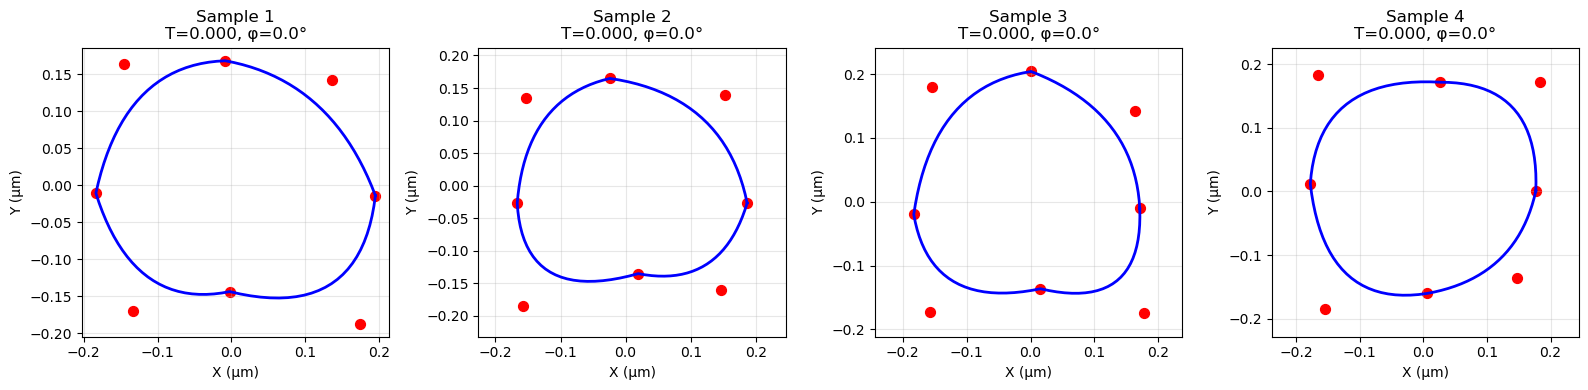

Figure saved as 'generated_shapes.png'


In [12]:
# Visualize some of the generated shapes
if control_points_data:
    n_show = min(4, len(control_points_data))
    fig, axes = plt.subplots(1, n_show, figsize=(4*n_show, 4))
    
    if n_show == 1:
        axes = [axes]
    
    for idx in range(n_show):
        ax = axes[idx]
        cp = control_points_data[idx]
        trans, phase = results_data[idx]
        
        # Generate NURBS curve
        temp_sim = Simulation(control_points=cp)
        nurbs_pts = temp_sim.generate_complete_nurbs_curve(cp)
        
        x = [p[0] for p in nurbs_pts] + [nurbs_pts[0][0]]
        y = [p[1] for p in nurbs_pts] + [nurbs_pts[0][1]]
        
        ax.plot(x, y, 'b-', linewidth=2)
        ax.scatter(cp[:, 0], cp[:, 1], c='red', s=50)
        ax.set_title(f'Sample {idx+1}\nT={trans:.3f}, φ={np.degrees(phase):.1f}°')
        ax.set_xlabel('X (μm)')
        ax.set_ylabel('Y (μm)')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('generated_shapes.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Figure saved as 'generated_shapes.png'")

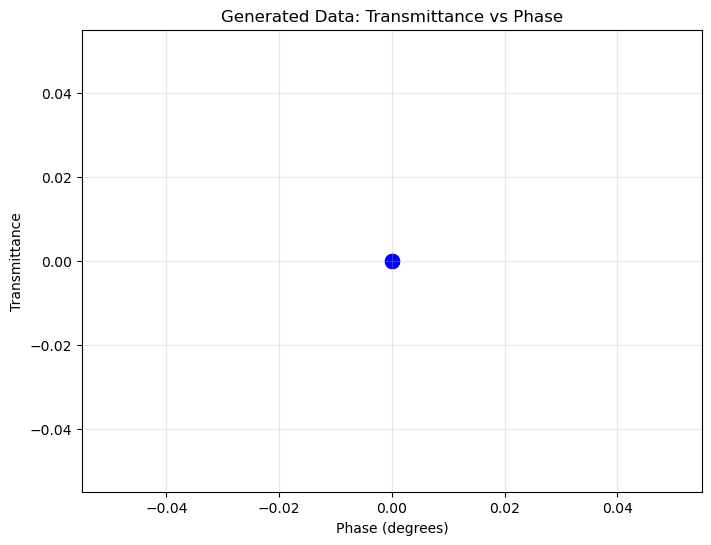

Figure saved as 'transmittance_vs_phase.png'


In [13]:
# Plot transmittance vs phase scatter
if results_data and len(results_data) > 1:
    plt.figure(figsize=(8, 6))
    transmittances = [r[0] for r in results_data]
    phases = [np.degrees(r[1]) for r in results_data]
    
    plt.scatter(phases, transmittances, c='blue', s=100, alpha=0.7)
    plt.xlabel('Phase (degrees)')
    plt.ylabel('Transmittance')
    plt.title('Generated Data: Transmittance vs Phase')
    plt.grid(True, alpha=0.3)
    plt.savefig('transmittance_vs_phase.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Figure saved as 'transmittance_vs_phase.png'")

## 4. Generate Larger Dataset (Optional)

Uncomment and run the cell below to generate a larger dataset for training.

In [14]:
# # Uncomment to generate larger dataset
# n_samples_large = 100  # Adjust as needed
# 
# print(f"Generating {n_samples_large} training samples...")
# control_points_large, results_large = generate_training_data(n_samples=n_samples_large)
# 
# # Save large dataset
# if control_points_large and results_large:
#     np.save('control_points_large.npy', np.array(control_points_large))
#     np.save('simulation_results_large.npy', np.array(results_large))
#     print(f"Large dataset saved! ({len(results_large)} samples)")

In [15]:
print("\n=== Notebook Complete ===")
print("You can now use the generated data for training the Transformer model.")


=== Notebook Complete ===
You can now use the generated data for training the Transformer model.
